In [1]:
import collections
from pathlib import Path
import json
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

from dataset.vqa import VQADataset,VQATorchDataset, VQAEvaluator

In [3]:
home = str(Path.home())
MSCOCO_IMGFEAT_ROOT = home + '/data/mscoco_imgfeat/'
VQA_DATA_ROOT = home+'/data/vqa/'

In [4]:
class Args():
    def __init__(self):
        self.tiny = True
        self.bs = 128
args = Args()

In [6]:
DataTuple = collections.namedtuple("DataTuple", 'dataset loader evaluator')

def get_data_tuple(path: str, mscoco_path: str, splits: str, tiny: bool,bs:int, shuffle=False, drop_last=False) -> DataTuple:
    dset = VQADataset(path,splits)
    tset = VQATorchDataset(dset,mscoco_path,tiny)
    evaluator = VQAEvaluator(dset)
    pin_memory = True if torch.cuda.is_available() else False
    data_loader = DataLoader(
        tset, batch_size=bs,
        shuffle=shuffle, num_workers=1,
        drop_last=drop_last, pin_memory=pin_memory
    )

    return DataTuple(dataset=dset,loader=data_loader, evaluator=evaluator)

train_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT, 'train,nominival', args.tiny, args.bs,True,True)
valid_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT,'minival',args.tiny,args.bs,True,True)

0it [00:00, ?it/s]

Load 632117 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


486it [00:02, 176.89it/s]
16it [00:00, 154.54it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


488it [00:02, 175.95it/s]
0it [00:00, ?it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset

Load 25994 data from split(s) minival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


493it [00:02, 180.54it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2546 data in torch dataset



In [7]:
dset = VQADataset(VQA_DATA_ROOT,'train,nominival')
tset = VQATorchDataset(dset,MSCOCO_IMGFEAT_ROOT,tiny=True)

0it [00:00, ?it/s]

Load 632117 data from split(s) train,nominival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv


492it [00:02, 180.17it/s]
20it [00:00, 190.22it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/train2014_obj36.tsv in 2 seconds.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


495it [00:02, 181.88it/s]


Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2810 data in torch dataset



In [8]:
from models.lxrt_adaptive import VQAModel_Adaptive

I0210 22:06:22.584024 140473802476416 file_utils.py:35] PyTorch version 1.4.0+cpu available.
/glob/intel-python/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [106]:
params = {'adapt_span_enabled': False, 'attn_span': 1024, 'adapt_span_loss_coeff': 0.000005, 
          'adapt_span_ramp': 32, 'adapt_span_init': 0.002, 'adapt_span_cache': True, 'nb_heads': 12,
          'bs': 128, 'mask_size': [20,36], 'sparse_enabled': False, 'num_attention_heads': 4, 
          'layer_sizes': {'lang':10,'cross':6,'vision':6}, 'from_scratch': False, 
          'layerdrop_enabled': True, 'layerdrop_num_layers': 1}

In [107]:
model = VQAModel_Adaptive(train_tuple[0].num_answers, params)

I0210 23:04:19.243330 140473802476416 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/u37216/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0210 23:04:19.631208 140473802476416 lxmert_utils.py:199] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0210 23:04:19.635339 140473802476416 lxmert_utils.py:207] extracting archive file /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /home/u37216/tmp/tmpcmg0dpm9
I0210 23:04:26.506544 140473

LXRT encoder with 10 l_layers, 6 x_layers, and 6 r_layers.
LayerDrop is enabled with dropping rate set to  1


In [108]:
#ckpt = torch.load(home+'/snap/adaptive_6910.pth', map_location=torch.device('cpu'))
ckpt = torch.load(home+'/snap/layerdrop_1066_ldrop_1.pth', map_location=torch.device('cpu'))
model.load_state_dict(ckpt)

<All keys matched successfully>

In [12]:
ques_id,feats,boxes,sent,target = next(iter(train_tuple[1]))

Traceback (most recent call last):
  File "/glob/intel-python/python3/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/glob/intel-python/python3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 480, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 438, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/glob/intel-python/python3/lib/python3.6/shutil.py", line 436, in _rmtree_safe_fd
    os.unlink(name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.nfs00000035000156190000113f'


In [109]:
logit = model(feats,boxes,sent)

In [110]:
logit.shape

torch.Size([128, 3129])

In [111]:
score, label = logit.max(1) # max_val, index

In [112]:
score.shape, label.shape

(torch.Size([128]), torch.Size([128]))

In [113]:
score[0], label[0]

(tensor(0.4457, grad_fn=<SelectBackward>), tensor(478))

In [114]:
dset = train_tuple[0]

In [115]:
for qid, l in zip(ques_id, label.cpu().numpy()):
    print(qid,l)
    break

tensor(111040003) 478


In [116]:
quesid2ans = {}
for qid, l in zip(ques_id, label.cpu().numpy()):
    ans = dset.label2ans[l]
    quesid2ans[qid.item()] = ans

In [117]:
quesid2ans

{7452005: 'blue',
 7558000: 'brown',
 8856005: 'no',
 18641000: 'wii',
 30820002: 'no',
 30820004: 'no light',
 33940000: 'green',
 33940002: 'left',
 35741003: 'no',
 37015001: 'yes',
 40071001: 'yes',
 40201008: 'qatar',
 42418001: 'playing tennis',
 54696010: 'biplane',
 54892000: 'woman',
 63873000: 'no',
 83456001: 'yes',
 83456003: 'wood',
 89425004: 'yes',
 95061005: 'yes',
 102604004: 'name',
 105817003: 'yes',
 111040003: 'sleeping',
 111940003: '3',
 111940011: 'no',
 114363011: 'parking',
 114363013: 'main',
 114945001: 'yes',
 118806000: 'giraffe',
 120615002: 'yes',
 126096005: 'blue',
 126096027: '20',
 126096036: 'tinkerbell',
 128599001: 'red',
 143439001: 'field',
 147178002: 'no',
 152557006: 'no',
 154625010: 'yes',
 154625018: 'evening',
 158322004: 'no',
 158694012: 'sand',
 158989000: 'yes',
 168607002: 'hungry',
 178553005: 'brown',
 184761002: 'yes',
 185236008: 'yes',
 186265035: 'yes',
 186265068: '1',
 186626010: 'white',
 186844000: 'no',
 189645001: 'cabbag

In [118]:
ans, qid.item()

('lab', 224958002)

In [119]:
idx_q = 42418001

In [120]:
qid = idx_q
ans = quesid2ans[idx_q]
ans

'playing tennis'

In [121]:
splits = 'train,nominival'
path = VQA_DATA_ROOT
splits = splits.split(',')

In [122]:
data = []
for split in splits:
    data.extend(json.load(open(path+"%s.json" % split)))

In [123]:
main_idx = 0
for idx,i in enumerate(data):
    if i['question_id']==qid: #qid.item():
        print(idx)
        main_idx = idx

150063


In [124]:
data[main_idx]

{'answer_type': 'other',
 'img_id': 'COCO_train2014_000000042418',
 'label': {'playing tennis': 0.9, 'swinging': 0.6, 'tennis': 1},
 'question_id': 42418001,
 'question_type': 'what is the man',
 'sent': 'What is the man doing?'}

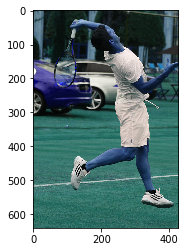

In [125]:
im = cv.imread(VQA_DATA_ROOT+'train'+'2014'+'/'+ data[main_idx]['img_id']+'.jpg')
im = plt.imshow(im)
im = plt.show()

## top k

In [126]:
logit[0].shape

torch.Size([3129])

In [127]:
scores_k, labels_k = torch.topk(logit, 5) 
labels_k.shape, scores_k.shape

(torch.Size([128, 5]), torch.Size([128, 5]))

In [128]:
quesid2ans_k = []
quesid2ans = {}
for i in range(len(labels_k)):
    qid = ques_id[i]
    ans = []
    for l in labels_k[i].cpu().numpy():
        #print(qid,l)
        ans.append(dset.label2ans[l])
        quesid2ans[qid.item()] = ans
    quesid2ans_k.append(quesid2ans) 

In [129]:
quesid2scores_k = []
quesid2scores = {}
for i in range(len(scores_k)):
    qid = ques_id[i]
    scores = []
    for l in scores_k[i].cpu().detach().numpy():
        scores.append(l)
        quesid2scores[qid.item()] = scores
    quesid2scores_k.append(quesid2scores) 

In [130]:
quesid2ans_k

[{7452005: ['blue', 'white', 'green', 'blue and white', 'gray'],
  7558000: ['brown', 'white', 'gray', 'green', 'tan'],
  8856005: ['no', 'yes', 'unknown', 'not sure', "can't tell"],
  18641000: ['wii', 'boxing', 'video game', 'golf', 'baseball'],
  30820002: ['no', 'yes', 'not sure', 'unknown', "can't tell"],
  30820004: ['no light', 'night', 'yes', 'black and white', 'shadow'],
  33940000: ['green', 'green and blue', 'blue', 'blue and green', 'yellow'],
  33940002: ['left', 'right', 'down', 'up', 'forward'],
  35741003: ['no', 'yes', 'unknown', 'not sure', "don't know"],
  37015001: ['yes', 'no', 'unknown', "can't tell", 'not sure'],
  40071001: ['yes', 'no', 'unknown', 'rust', 'not sure'],
  40201008: ['qatar', 'american', 'southwest', 'thai', 'hawaiian'],
  42418001: ['playing tennis', 'tennis', 'playing', 'swinging', 'serving'],
  54696010: ['biplane', 'jet', 'airplane', 'plane', 'cessna'],
  54892000: ['woman', 'man', "woman's", "man's", 'lady'],
  63873000: ['no', 'yes', 'zebra'

In [131]:
idx_q = 42418001

In [132]:
qid = idx_q
ans = quesid2ans[idx_q]
scores = quesid2scores[idx_q]
ans, scores

(['playing tennis', 'tennis', 'playing', 'swinging', 'serving'],
 [2.3263187, 0.7738012, -2.7131598, -2.8683007, -3.1115787])

In [133]:
# def label2ans(labels):
#     classes = []
#     for i in range(len(labels)):
#         classes.append(dset.label2ans[labels[i].item()])
#     return classes
# labels_k_str = label2ans(labels_k)

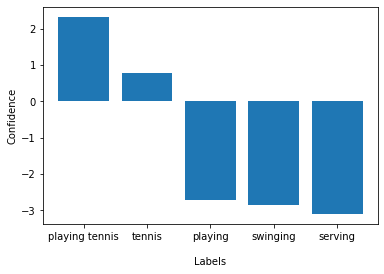

In [135]:
plt.bar(ans, scores)
plt.xlabel('\nLabels')
plt.ylabel('Confidence')
plt.show()